In [101]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn import preprocessing
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Urbansurge imports.
from urbansurge import swmm_model
from urbansurge.fault_diagnosis import ann_severity_regressor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
# Concatenate fault database csv files.
csv_dir = Path(r'C:\Users\ay434\Documents\urbansurge\analysis\lab_system\Output')

csv_fnames = [
    'diameter_impulse_fault_database.csv',
#     'roughness_impulse_fault_database.csv',
#     'silting_impulse_fault_database.csv'
]

# Load in fault data frames as a list.
df_list = [pd.read_csv(csv_dir / f) for f in csv_fnames]

# Concatenate into a single data frame.
fault_database_df = pd.concat(df_list)
fault_database_df.reset_index(drop=True, inplace=True)

# Number of unique component, fault value, and fault type combinations.
grouped = fault_database_df.groupby(['fault_component', 'fault_value', 'fault_type'])
ngroups = grouped.ngroups
print(grouped.size())

# Load in fault-free system data frame.
healthy_fname = 'healthy_impulse_database.csv'
healthy_database_df = pd.read_csv(csv_dir / healthy_fname)

fault_component  fault_value  fault_type
76               0.1          diameter      360
                 0.2          diameter      360
                 0.3          diameter      360
                 0.4          diameter      360
                 0.5          diameter      360
                 0.6          diameter      360
                 0.7          diameter      360
                 0.8          diameter      360
                 0.9          diameter      360
77               0.1          diameter      360
                 0.2          diameter      360
                 0.3          diameter      360
                 0.4          diameter      360
                 0.5          diameter      360
                 0.6          diameter      360
                 0.7          diameter      360
                 0.8          diameter      360
                 0.9          diameter      360
78               0.1          diameter      360
                 0.2          diameter      360

In [151]:
# Depth and velocity columns.
dep_vel_cols = [s for s in healthy_database_df if any(sub in s for sub in ['Depth_link', 'Velocity'])]

# Select sensors.
sensor_links = [20]#[37, 62, 63, 65, 60, 34, 33, 38, 21, 20]
dep_cols = [f'Depth_link_{s}' for s in sensor_links]
vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
dep_vel_cols = dep_cols + vel_cols
extra_fault_cols = [col for col in fault_database_df.columns if col not in dep_vel_cols]

# Depth and velocity data from fault database.
fault_sensor_ar = fault_database_df[dep_vel_cols].to_numpy()

# Add Gaussian noise to fault sensor array.
fault_sensor_ar = fault_sensor_ar + np.random.normal(0, 0.0, size=fault_sensor_ar.shape)

# Depth and velocity data from healthy database.
healthy_sensor_ar = healthy_database_df[dep_vel_cols].to_numpy()

# Number of times to repeat the healthy sensor data.
repeats = ngroups
healthy_repeats = np.repeat(healthy_sensor_ar, repeats, axis=0)

# Create residual data.
residual_ar = healthy_repeats - fault_sensor_ar

# Residual data frame with fault data added back in. 
residual_df = pd.DataFrame(residual_ar, columns=dep_vel_cols)
residual_df = pd.merge(residual_df, fault_database_df[extra_fault_cols], left_index=True, right_index=True)

### Normalize depth residuals by maximum depth and velocity by link.

In [152]:
# Path to configuration file.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

# Link IDs.
link_ids = np.unique([int(re.search(r'[^_]+$', s).group(0)) for s in dep_vel_cols])

# Loop through link IDs and normalize depth and velocity residuals.
for link_id in link_ids:
    # Get pipe diameter.
    max_depth = swmm.get_link_geometry(link_id)[0]
    
    # Maximum velocity occurs at 78% of diameter.
    d_vmax = 0.78 * max_depth
    
    # Link roughness.
    n = swmm.get_link_roughness(link_id)
    
    # Link slope.
    S = swmm.get_link_slope(link_id)
    S = np.abs(S)
    
    # Link hydraulic radius at maximum velocity depth.
    Rh = swmm.get_link_circular_Rh(d_vmax, max_depth)
    
    # Compute maximum velocity.
    max_velocity = (1.49 / n) * Rh**(2/3) * S**(1/2)
    
    # Normalize depth.
    residual_df[f'Depth_link_{link_id}'] = residual_df[f'Depth_link_{link_id}'] / max_depth
    
    # Normalize velocity.
    residual_df[f'Velocity_link_{link_id}'] = residual_df[f'Velocity_link_{link_id}'] / max_velocity

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


In [153]:
# Features.
X = residual_df[dep_vel_cols].to_numpy()

# Labels.
# y = residual_df.loc[:, ['fault_component', 'fault_value', 'fault_type', 'storm']].to_numpy()
y = residual_df.loc[:, ['fault_component', 'fault_value', 'fault_type']].to_numpy()

# Split the training data on the storm ID.
y_df = pd.DataFrame(y)

# Add an index to maintain the original order
y_df['index'] = y_df.index

# Group by the labels
grouped = y_df.groupby(list(y_df.columns[:-1]))

# Extract the indices for each group
group_indices = [group.index.tolist() for _, group in grouped]

# Check sizes of groups.
group_sizes = set([len(g) for g in group_indices])
print('Group Sizes', set([len(g) for g in group_indices]))
max_group_size = max(group_sizes)
min_group_size = min(group_sizes)

# Separate data from X into images.
Ximg = np.zeros((max_group_size, X.shape[1], len(group_indices)))
for i, idxs in enumerate(group_indices):
    # Extract images.
    img = X[group_indices[i],:]
    Ximg[:img.shape[0],:,i] = img
    
# Cut to minimum group size.
Ximg = Ximg[:min_group_size,:,:]

# Stack columns.
Ximg = Ximg.transpose(1, 0, 2).reshape(-1, Ximg.shape[2]).T

# # Remove sensors.
# Ximg = Ximg[:,1:10,:]
    
yimg = y[[g[0] for g in group_indices]]

Group Sizes {360}


### ANN classifier.

(45, 720)
<class 'float'>


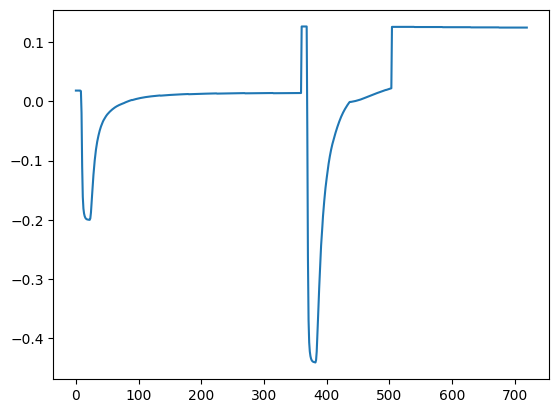

In [154]:
print(Ximg.shape)

print(type(yimg[0,1]))

fig, ax = plt.subplots()
ax.plot(Ximg[10,:])

In [159]:
# =================================================================
class ANNDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
            
        return data, label
    
# Create tensors to pass into ANN.
Ximg_ann = torch.tensor(Ximg, dtype=torch.float32)
yimg_sev = np.array(yimg[:,1]).astype(float)
yimg_ann = torch.tensor(yimg_sev, dtype=torch.float32)
yimg_ann = yimg_ann.unsqueeze(1)
print(Ximg_ann.shape)

# Create the dataset and dataloader
dataset = ANNDataset(Ximg_ann, yimg_ann)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train, validation, test split.
generator1 = torch.Generator().manual_seed(40)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2], generator=generator1)

# Dataloaders.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Model, loss function, and optimizer
model = ann_severity_regressor.SimpleANN()
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 1000  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print(epoch)

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
            
print('Training finished.')

torch.Size([45, 720])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271


### Test severity regressor.

In [160]:
# Set the model to evaluation mode
model.eval()

# Storage for predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient calculations for efficiency
with torch.no_grad():
    for inputs, labels in test_loader:
        # If using a GPU, move data to GPU
        # inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass: compute the model output
        outputs = model(inputs)

#         # For classification, get the class index with the highest score
#         _, predicted = torch.max(outputs, 1)

        # Store predictions and labels
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays if necessary
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [161]:
# Roughness.
n_predictions = all_predictions * 0.01
n_labels = all_labels * 0.01
print(n_predictions.T)
print(n_labels.T)

print(np.size(n_labels))
print(np.sum(np.abs(n_predictions - n_labels)) / np.size(n_labels))

# Diameter.
print(all_predictions.T)
print(all_labels.T)

print(np.size(all_labels))
print(np.sum(np.abs(all_predictions - all_labels)) / np.size(all_labels))

[[0.5352308  0.32041255 0.91123366 0.17461717 0.21416637 0.29726818
  0.15592305 0.6258972  0.2047845 ]]
[[0.5        0.39999998 0.9        0.09999999 0.19999999 0.3
  0.09999999 0.9        0.9       ]]
9
0.1380898422665066
[[53.523083 32.041256 91.12337  17.461718 21.416637 29.726818 15.592306
  62.589725 20.47845 ]]
[[50.       40.       90.       10.       20.       30.000002 10.
  90.       90.      ]]
9
13.808983696831596
